### Notebook to perform SMOTE

In [1]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import utils

from imblearn.over_sampling import SMOTE
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [2]:
INPUT_DATA_FILE = 'data/eanci/eanci_data.txt'
INPUT_LABEL_FILE = 'data/eanci/eanci_labels.txt'

OUTPUT_DATA_FILE = 'data/eanci/eanci_data_balanced.txt'
OUTPUT_LABEL_FILE = 'data/eanci/eanci_labels_balanced.txt'

'''
Ratio defining how many synthetic minority samples should be created. 1.0 results in a fully balanced set.
Float on interval (0.0, 1.0]
'''
BALANCE_RATIO = 1.0

'''
Specify number of words in a sequence for vectorize layer.
Sequence stats and lengths plot found below.
'''
SEQUENCE_LENGTH = 500

In [3]:
training_data = []
labels = []
lengths = []

In [4]:
# Load metadocs
with open(INPUT_DATA_FILE, newline='') as datafile:
    data_reader = csv.reader(datafile, delimiter='\n')
    
    for row in data_reader:
        training_data.append(row[0])

In [5]:
# Load labels
with open(INPUT_LABEL_FILE, newline='') as labelfile:
    label_reader = csv.reader(labelfile, delimiter='\n')
    
    for row in label_reader:
        labels.append(int(row[0]))

In [6]:
# Sequence information for loaded set
for seq in training_data:
    lengths.append(len(seq.split()))

print('Number of metadocuments: ', len(training_data))
print('Vocab size: ', utils.vocabulary_size(training_data))
print('Avg seq length: ', sum(lengths) / len(lengths))
print('Min seq len: ', min(lengths))
print('Max seq len: ', max(lengths))

Number of metadocuments:  7645
Vocab size:  1299
Avg seq length:  502.5982995421844
Min seq len:  56
Max seq len:  2367


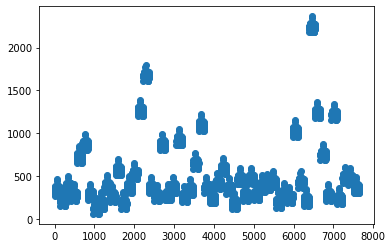

In [7]:
# Plot the sequence length of each metadocument in the dataset
X = [x for x in range(len(lengths))]

plt.scatter(X, lengths)
plt.show()

In [8]:
# Convert data and labels to TF dataset in order to use TextVectorization
unbalanced_data = [tf.convert_to_tensor(metadoc) for metadoc in training_data]
unbalanced_ds = tf.data.Dataset.from_tensor_slices((unbalanced_data,labels)).batch(32)

In [9]:
'''
Use the text vectorization layer to split, prune and map strings to integers.
Set maximum_sequence length as all samples are not of the same length.
'''
vectorize_layer = TextVectorization(
    output_mode='int',
    output_sequence_length=SEQUENCE_LENGTH)

# Load vocab into vectorization layer
vectorize_layer.set_vocabulary(utils.get_vocabulary(training_data))

In [10]:
# List structure
tf_vocab = vectorize_layer.get_vocabulary()

In [11]:
print(tf_vocab)

['', '[UNK]', 'gi', 'sorg', 'nametab8', 'parchegg', 'entrar', 'descrizion', 'forward', 'pubblic', 'uffici', 'ippa', 'logout', 'smarr', 'possess', 'richied', 'dirett', 'pagin', 'ragazz', 'intopp', 'increment', 'failur', 'user', 'nc', 'apertur', 'manag', 'domand', 'gg', 'surnametab4', 'costier', 'pericol', 'pag', 'percor', 'amm', 'puntualizz', 'idf', 'v2', 'dip', 'interag', 'corrispond', 'annul', 'ripres', 'check', 'familiar', 'type', 'surnametab8', 'sol', 'esemp', 'termin', 'surnametab6', 'seguent', 'attrav', 'nomec', 'surnametab2', 'indenn', 'mm', 'statofamigl', 'svolt', 'dichiar', 'bold', 'canc', 'rispond', 'cpassword', 'send', 'immess', 'localhost', 'sussist', 'telef', 'hidden', 'paramet', 'veng', 'contien', 'exe', 'esit', 'tossicolog', 'bosc', 'priv', 'compet', 'ricav', 'nametab1', 'press', 'justifi', 'campion', 'ab', 'oltr', 'cod', 'esecut', 'prec', 'eff', 'transfer', 'domicil', 'stmt', 'anali', 'particol', 'inscrizion', 'aa6', 'connect', 'igien', 'motor', 'rallent', 'ilsistemaelim

In [12]:
# Get original vocabulary from unbalanced training data
vocab = utils.get_vocabulary(training_data)
inverse_vocab = {}

'''
Create an inverse vocabulary so we can decode the balanced vectorized data.
Index of word in vectorization layer's vocabulary maps to it's int encoding.
'''
for i, word in enumerate(tf_vocab):
    inverse_vocab[i] = word

In [13]:
'''
Print any words added to vocab by TF.
Expected: empty string and [UNK]
'''
for word in enumerate(tf_vocab):    
    if word[1] not in vocab:
        if word[1] == '':
            print('empty string')
        else:
            print(word[1])

empty string
[UNK]


In [14]:
print(inverse_vocab)

{0: '', 1: '[UNK]', 2: 'gi', 3: 'sorg', 4: 'nametab8', 5: 'parchegg', 6: 'entrar', 7: 'descrizion', 8: 'forward', 9: 'pubblic', 10: 'uffici', 11: 'ippa', 12: 'logout', 13: 'smarr', 14: 'possess', 15: 'richied', 16: 'dirett', 17: 'pagin', 18: 'ragazz', 19: 'intopp', 20: 'increment', 21: 'failur', 22: 'user', 23: 'nc', 24: 'apertur', 25: 'manag', 26: 'domand', 27: 'gg', 28: 'surnametab4', 29: 'costier', 30: 'pericol', 31: 'pag', 32: 'percor', 33: 'amm', 34: 'puntualizz', 35: 'idf', 36: 'v2', 37: 'dip', 38: 'interag', 39: 'corrispond', 40: 'annul', 41: 'ripres', 42: 'check', 43: 'familiar', 44: 'type', 45: 'surnametab8', 46: 'sol', 47: 'esemp', 48: 'termin', 49: 'surnametab6', 50: 'seguent', 51: 'attrav', 52: 'nomec', 53: 'surnametab2', 54: 'indenn', 55: 'mm', 56: 'statofamigl', 57: 'svolt', 58: 'dichiar', 59: 'bold', 60: 'canc', 61: 'rispond', 62: 'cpassword', 63: 'send', 64: 'immess', 65: 'localhost', 66: 'sussist', 67: 'telef', 68: 'hidden', 69: 'paramet', 70: 'veng', 71: 'contien', 72

In [15]:
# Create np arrays to store vectorized data
vectorized_data = np.zeros((len(training_data), SEQUENCE_LENGTH))
vectorized_labels = np.zeros(len(training_data))
i = 0

# Vectorize data and arrays for data balancing
for batch in unbalanced_ds:
    for sequence, label in zip(vectorize_layer(batch[0]), batch[1]):
        vectorized_data[i] = sequence
        vectorized_labels[i] = label 
        i += 1

In [16]:
# Check vectors for [UNK]  and empty string in sequence
num_unk = 0
num_empty = 0

for row in vectorized_data:
    for val in row:
        if val == 0:
            num_empty += 1
        elif val == 1:
            num_unk += 1
            
print('Percent empty tokens: %f' %((num_empty/(len(training_data * SEQUENCE_LENGTH)))*100))
print('Percent unk tokens: %f' %((num_unk/(len(training_data * SEQUENCE_LENGTH)))*100))

Percent empty tokens: 28.517096
Percent unk tokens: 0.000000


In [17]:
# Perform SMOTE on loaded dataset
balanced_data_enc, balanced_labels = SMOTE(sampling_strategy=BALANCE_RATIO).fit_resample(vectorized_data, vectorized_labels)

In [18]:
# Create new data and label files for balanced set.
with open(OUTPUT_DATA_FILE, 'w', newline='') as datafile:
    data_writer = csv.writer(datafile, quoting=csv.QUOTE_MINIMAL)

    with open(OUTPUT_LABEL_FILE, 'w', newline='') as labelfile:
        label_writer = csv.writer(labelfile, quoting=csv.QUOTE_MINIMAL)  

        i = 0
        for row, label in zip(balanced_data_enc, balanced_labels):
            decoded = []
            for val in row:
                decoded.append(inverse_vocab[int(val)])
                
            # we will get double spaces due to a 0 being mapped to '' 
            data_writer.writerow([' '.join(decoded)])
            label_writer.writerow([int(label)])
            i+=1